In [1]:
import neuron
from neuron import h
from neuron.units import ms, mV
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import json
import os
import ipywidgets as widgets
from ipywidgets import interactive_output, HBox, VBox, Label, Layout
from IPython.display import display
from IPython.display import clear_output
%matplotlib inline

h.load_file('stdrun.hoc')
mechanisms_dir = '../components/mechanisms'
templates_file = '../components/templates/templates.hoc'
neuron.load_mechanisms(mechanisms_dir)
h.load_file(templates_file) # reads in template

h.dt = 0.025 # time step (resolution) of the simulation in ms
h.steps_per_ms = 1 / h.dt
h.celsius = 20.0

### Set parameters for different connection types

#### Basic settings

In [2]:
default_settings = {
    'post_cell': 'CP_Cell',
    'sec_id': 1,
    'sec_x': 0.5,
    'syn_type': 'exc',
    'syn_mech': 'Exp2Syn_STP',
    'vclamp': False,
    'vclamp_amp': -60.,
    'rise_interval': (0., 1 - 1e-3),
    'tstart': 500.,
    'tdur': 50.,
    'threshold': 0., # netcon
    'delay': 1.3, # netcon
    'weight': 1., # netcon
}
setting_dict = {
    'exc': {'vclamp_amp': -70.},
    'inh': {'vclamp_amp': -55.},
}
syn_param_exc = {
    'initW': 1.0,
    'tau1': 0.2, # (ms) Dual-exponential conductance profile
    'tau2': 10.0, # (ms) IMPORTANT: tau_r < tau_d
    'Use': 1., # (1) Utilization of synaptic efficacy
    'Dep': 100., # (ms) Relaxation time constant from depression
    'Fac': 10., # (ms) Relaxation time constant from facilitation
}
syn_param_inh = {
    'initW': 1.0,
    'e': -75.,
    'tau1': 1.0, # (ms) Dual-exponential conductance profile
    'tau2': 20., # (ms) IMPORTANT: tau_r < tau_d
    'Use': 1., # (1) Utilization of synaptic efficacy
    'Dep': 100., # (ms) Relaxation time constant from depression
    'Fac': 10., # (ms) Relaxation time constant from facilitation
}
syn_param_dict = {'exc': syn_param_exc, 'inh': syn_param_inh}

#### Settings for individual conection types

In [3]:
conn_type_settings = {
    'CP2CP': {
        'spec_settings': {
            'post_cell': 'CP_Cell',
            'sec_x': 0.4,
        },
        'spec_syn_param': {
            'initW': 1.12,
            'tau2': 10.,
            'Use': 0.23,
            'Dep': 600.,
            'Fac': 0.,
        },
    },
    'CP2CS': {
        'spec_settings': {
            'post_cell': 'CS_Cell',
            'sec_x': 0.4,
        },
        'spec_syn_param': {
            'initW': 0.6,
            'tau2': 10.,
            'Use': 0.23,
            'Dep': 600.,
            'Fac': 0.,
        },
    },
    'CS2CS': {
        'spec_settings': {
            'post_cell': 'CS_Cell',
            'sec_x': 0.4,
        },
        'spec_syn_param': {
            'initW': 0.8,
            'tau1': 0.9,
            'tau2': 4.,
            'Use': 0.19,
            'Dep': 360.,
            'Fac': 25.
        },
    },
    'CS2CP': {
        'spec_settings': {
            'post_cell': 'CP_Cell',
            'sec_x': 0.4,
        },
        'spec_syn_param': {
            'initW': 2.2,
            'tau1': 0.8,
            'tau2': 4.4,
            'Use': 0.103,
            'Dep': 580.,
            'Fac': 40.
        },
    },
    'CP2FSI': {
        'spec_settings': {
            'post_cell': 'FSI_Cell',
        },
        'spec_syn_param': {
            'initW': 3.6,
            'tau1': 0.1,
            'tau2': 0.9,
            'Use': 0.23,
            'Dep': 825.,
            'Fac': 0.
        },
    },
    'CS2FSI': {
        'spec_settings': {
            'post_cell': 'FSI_Cell',
        },
        'spec_syn_param': {
            'initW': 1.65,
            'tau1': 0.1,
            'tau2': 0.9,
            'Use': 0.24,
            'Dep': 400.,
            'Fac': 60.
        },
    },
    'CP2LTS': {
        'spec_settings': {
            'post_cell': 'LTS_Cell',
        },
        'spec_syn_param': {
            'initW': 0.12,
            'tau1': 0.1,
            'tau2': 13.,
            'Use': 0.22,
            'Dep': 240.,
            'Fac': 500.
        },
    },
    'CS2LTS': {
        'spec_settings': {
            'post_cell': 'LTS_Cell',
        },
        'spec_syn_param': {
            'initW': 0.6,
            'tau1': 0.1,
            'tau2': 3.,
            'Use': 0.24,
            'Dep': 120.,
            'Fac': 500.
        },
    },
    'FSI2CP': {
        'spec_settings': {
            'post_cell': 'CP_Cell',
            'sec_id': 0,
            'syn_type': 'inh',
        },
        'spec_syn_param': {
            'initW': 1.6,
            'tau1': 1.,
            'tau2': 33.,
            'e': -90.,
            'Use': 0.65,
            'Dep': 275.,
            'Fac': 0.
        },
    },
    'FSI2CS': {
        'spec_settings': {
            'post_cell': 'CS_Cell',
            'sec_id': 0,
            'syn_type': 'inh',
        },
        'spec_syn_param': {
            'initW': 6.0,
            'tau1': 1.1,
            'tau2': 28.,
            'e': -90.,
            'Use': 0.56,
            'Dep': 750.,
            'Fac': 0.
        },
    },
    'LTS2CP': {
        'spec_settings': {
            'post_cell': 'CP_Cell',
            'sec_id': 2,
            'sec_x': 0.8,
            'syn_type': 'inh',
        },
        'spec_syn_param': {
            'initW': 2.0,
            'tau1': 1.4,
            'tau2': 30.,
            'e': -90.,
            'Use': 0.34,
            'Dep': 175.,
            'Fac': 550.
        },
    },
    'LTS2CS': {
        'spec_settings': {
            'post_cell': 'CS_Cell',
            'sec_id': 2,
            'sec_x': 0.8,
            'syn_type': 'inh',
            'vclamp': False,
        },
        'spec_syn_param': {
            'initW': 2.0,
            'tau1': 0.8,
            'tau2': 29.,
            'e': -90.,
            'Use': 0.37,
            'Dep': 300.,
            'Fac': 750.
        },
    },
    'FSI2FSI': {
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'sec_id': 0,
            'syn_type': 'inh',
        },
        'spec_syn_param': {
            'initW': 8.5,
            'tau1': 0.1,
            'tau2': 4.9,
            'Use': 0.22,
            'Dep': 600.,
            'Fac': 0.
        },
    },
    'FSI2LTS': {
        'spec_settings': {
            'post_cell': 'LTS_Cell',
            'sec_id': 0,
            'syn_type': 'inh',
        },
        'spec_syn_param': {
            'initW': 6.0,
            'tau1': 0.1,
            'tau2': 6.5,
            'Use': 0.26,
            'Dep': 500.,
            'Fac': 10.
        },
    },
    'LTS2FSI': {
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'sec_id': 0,
            'syn_type': 'inh',
        },
        'spec_syn_param': {
            'initW': 1.6,
            'tau1': 0.8,
            'tau2': 4.9,
            'Use': 0.32,
            'Dep': 100.,
            'Fac': 520.
        },
    },
    'LTS2LTS': {
        'spec_settings': {
            'post_cell': 'LTS_Cell',
            'sec_id': 0,
            'syn_type': 'inh',
        },
        'spec_syn_param': {
            'initW': 0.6,
            'tau1': 0.8,
            'tau2': 27.,
            'Use': 0.47,
            'Dep': 250.,
            'Fac': 0.
        },
    },
}

In [4]:
Connection = 'CP2LTS'

conn_type_setting = conn_type_settings[Connection]
settings = default_settings.copy()
settings.update(setting_dict[settings['syn_type']])
settings.update(conn_type_setting['spec_settings'])
syn_param = syn_param_dict[settings['syn_type']].copy()
syn_param.update(conn_type_setting['spec_syn_param'])

### Set up model for simulation

In [5]:
tstart = settings['tstart']
tdur = settings['tdur']
h.tstop = tstart + tdur # how long to run the simulation in ms

cell = getattr(h, settings['post_cell'])()
syn = getattr(h, settings['syn_mech'])(list(cell.all)[settings['sec_id']](settings['sec_x']))
nstim = h.NetStim()
nstim.start = tstart
nstim.noise = 0
nstim2 = h.NetStim()
nstim2.start = h.tstop
nstim2.noise = 0
nc = h.NetCon(nstim, syn, settings['threshold'], settings['delay'], settings['weight'])
nc2 = h.NetCon(nstim2, syn, settings['threshold'], settings['delay'], settings['weight'])
vcl = h.VClamp(cell.soma[0](0.5))
vcldur = [[0, 0, 0], [tstart, h.tstop, 1e9]]
vcl_on = True
for i in range(3):
    vcl.amp[i] = settings['vclamp_amp']

def switch_vclamp(on=True):
    global vcl_on
    vcl_on = on
    on = int(on)
    for i in range(3):
        vcl.dur[i] = vcldur[on][i]

switch_vclamp(settings['vclamp'])

t = h.Vector() # Vectors are used to record data in the simulation
tspk = h.Vector() # synapse event times
soma_v = h.Vector()
ivcl = h.Vector()
isyn = h.Vector()
Use_rec = h.Vector()
Pr = h.Vector()
# record data
t.record(h._ref_t)
nc.record(tspk)
nc2.record(tspk)
soma_v.record(cell.soma[0](0.5)._ref_v)
ivcl.record(vcl._ref_i)
isyn.record(syn._ref_i)
Pr.record(syn._ref_Pr)
Use_rec.record(syn._ref_u)

Vector[5]

### Single synaptic event and evaluate properties

#### Functions for estimating synaptic properties

In [6]:
def find_first(x):
    x = np.asarray(x)
    idx = np.nonzero(x)[0]
    if idx.size:
        return idx[0]
    else:
        return None

def get_syn_prop(isyn, tspk, rise_interval=(0.2, 0.8), dt=h.dt, short=False):
    isyn = np.asarray(isyn)
    tspk = np.asarray(tspk)
    if tspk.size:
        tspk = tspk[0]
    ispk = int(np.floor(tspk / dt))
    baseline = isyn[ispk]
    isyn = isyn[ispk:] - baseline
    sign = np.sign(isyn[np.argmax(np.abs(isyn))])
    if short:
        return {'baseline': baseline, 'sign': sign}
    isyn *= sign
    # peak amplitude
    ipk, _ = find_peaks(isyn)
    ipk = ipk[0]
    peak = isyn[ipk]
    # latency
    istart = find_first(np.diff(isyn[:ipk + 1]) > 0)
    latency = dt * (istart + 1)
    # rise time
    rt1 = find_first(isyn[istart:ipk + 1] > rise_interval[0] * peak)
    rt2 = find_first(isyn[istart:ipk + 1] > rise_interval[1] * peak)
    rise_time = (rt2 - rt1) * dt
    # decay time
    iend = find_first(np.diff(isyn[ipk:]) > 0)
    iend = isyn.size - 1 if iend is None else iend + ipk
    decay_len = iend - ipk + 1
    popt, _ = curve_fit(lambda t, a, tau: a * np.exp(-t / tau), dt * np.arange(decay_len),
                        isyn[ipk:iend + 1], p0=(peak, dt * decay_len / 2))
    decay_time = popt[1]
    # half-width
    hw1 = find_first(isyn[istart:ipk + 1] > 0.5 * peak)
    hw2 = find_first(isyn[ipk:] < 0.5 * peak)
    hw2 = isyn.size if hw2 is None else hw2 + ipk
    half_width = dt * (hw2 - hw1)
    output = {'baseline': baseline, 'sign': sign, 'latency': latency,
          'amp': peak, 'rise_time': rise_time, 'decay_time': decay_time, 'half_width': half_width}
    return output

In [7]:
print(syn_param)
# change synaptic parameters for tuning
'''
syn_param.update({
    'initW': 1.0,
    'tau1': 0.8, # (ms) Dual-exponential conductance profile
    'tau2': 27., # (ms) IMPORTANT: tau_1 < tau_2
    # 'Use': 1.0,
})
print(syn_param)
# '''
for key, value in syn_param.items():
    setattr(syn, key, value)

switch_vclamp(False)
# switch_vclamp(True)

h.tstop = tstart + tdur
nstim.interval = tdur
nstim.number = 1
nstim2.start = h.tstop

h.run()

{'initW': 0.12, 'tau1': 0.1, 'tau2': 13.0, 'Use': 0.22, 'Dep': 240.0, 'Fac': 500.0}


0.0

In [8]:
# synaptic current
syn_prop = get_syn_prop(isyn if vcl_on else soma_v, tspk, rise_interval=settings['rise_interval'])
print(json.dumps(syn_prop, indent=2))
if vcl_on: # clamp current
    syn_prop_vcl = get_syn_prop(ivcl, tspk, rise_interval=settings['rise_interval'])
    print(json.dumps(syn_prop_vcl, indent=2))

{
  "baseline": -69.99999999996699,
  "sign": 1.0,
  "latency": 1.35,
  "amp": 0.1582179888959132,
  "rise_time": 15.25,
  "decay_time": 36.520306991579886,
  "half_width": 40.45
}


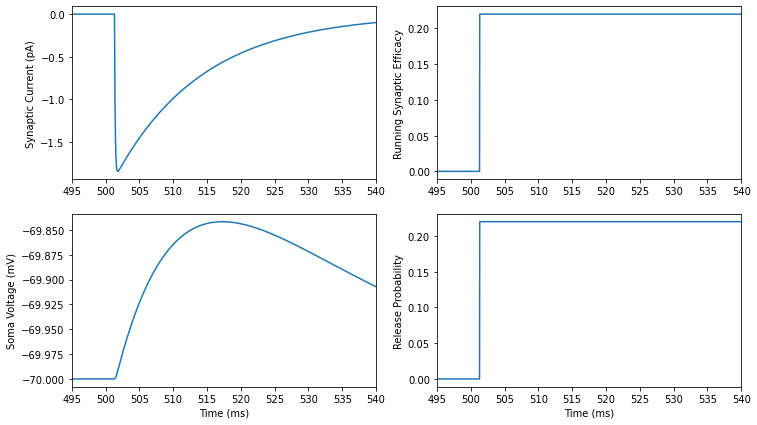

In [9]:
def plot_model(xlim=[]):
    fig, axs = plt.subplots(2, 2, figsize=(12, 7))
    axs = axs.ravel()
    axs[0].plot(t, 1000 * isyn)
    axs[0].set_ylabel('Synaptic Current (pA)')
    ispk = int(np.round(tspk[0] / h.dt))
    if vcl_on:
        baseline = ivcl[ispk]
        ivcl_plt = np.array(ivcl) - baseline
        ivcl_plt[:ispk] = 0
        axs[2].plot(t, 1000 * ivcl_plt)
        axs[2].set_ylabel('VClamp Current (pA)')
    else:
        soma_v_plt = np.array(soma_v)
        soma_v_plt[:ispk] = soma_v_plt[ispk]
        axs[2].plot(t, soma_v_plt)
        axs[2].set_ylabel('Soma Voltage (mV)')
    axs[1].plot(t, Use_rec)
    axs[1].set_ylabel('Running Synaptic Efficacy')
    axs[3].plot(t, Pr)
    axs[3].set_ylabel('Release Probability')
    for i, ax in enumerate(axs):
        ax.set_xlim(*xlim)
        if i > 1:
            ax.set_xlabel('Time (ms)')
    plt.show()

plot_model([tstart - 5, tstart + 40])

### Short term plasticity

In [10]:
freqs = [10, 20, 50, 100, 200]
delays = [125, 250, 500, 1000, 2000, 4000]
freq0 = 50
delay0 = 250

n_init_pulse = 8
n_ending_pulse = 4

def set_drive_train(freq=50., delay=250.):
    """Drive trains of 12 action potentials at frequency `freq` (Hz)
    with a delay period `delay` (ms) between the 8th and 9th pulses.
    """
    nstim.interval = 1000 / freq
    nstim2.interval = 1000 / freq
    nstim.number = n_init_pulse
    nstim2.number = n_ending_pulse
    nstim2.start = nstim.start + (n_init_pulse - 1) * nstim.interval + delay
    tstop = nstim2.start + n_ending_pulse * nstim2.interval
    return tstop

def response_amplitude(isyn, tspk, dt=h.dt):
    isyn = np.asarray(isyn)
    tspk = np.append(np.asarray(tspk), h.tstop)
    syn_prop = get_syn_prop(isyn, tspk, dt=dt, short=True)
    isyn = (isyn - syn_prop['baseline']) * syn_prop['sign']
    ispk = np.floor((tspk + settings['delay']) / dt).astype(int)
    amp = [isyn[ispk[i]:ispk[i + 1]].max() for i in range(ispk.size - 1)]
    return amp

def induction_recovery(amp, normalize_by_trial=True):
    amp = np.array(amp)
    amp = amp.reshape(-1, amp.shape[-1])
    maxamp = amp.max(axis=1 if normalize_by_trial else None)
    induction = np.mean((amp[:, 5:8].mean(axis=1) - amp[:, :1].mean(axis=1)) / maxamp)
    recovery = np.mean((amp[:, 8:12].mean(axis=1) - amp[:, :4].mean(axis=1)) / maxamp)
    maxamp = maxamp.max()
    return induction, recovery, maxamp

def set_syn_prop(weight, Use, tau_f, tau_d):
    syn.initW = weight #synaptic weight for our synapse
    syn.Fac = tau_f
    syn.Dep = tau_d
    syn.Use = Use

def simulate_model(input_frequency, delay, vclamp=None):
    h.tstop = set_drive_train(input_frequency, delay)
    if vclamp is not None:
        if vclamp:
            vcldur[1][1] = h.tstop
        switch_vclamp(vclamp)
    h.finitialize(cell.Vinit * mV)
    h.continuerun(h.tstop * ms)

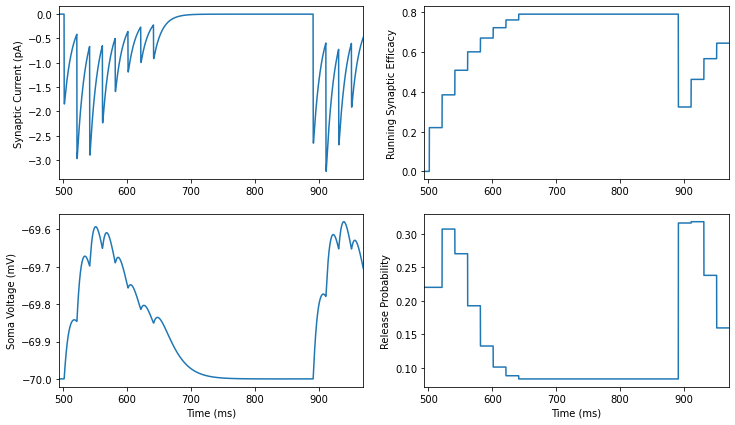

Single trial PSP
Induction: 0.11; Recovery: 0.07
Rest Amp: 0.16; Maximum Amp: 0.42


In [11]:
w_run = widgets.Button(description='Run', icon='history', button_style='primary')
w_vclamp = widgets.ToggleButton(value=False, description='Voltage Clamp', icon='check', button_style='primary')
w_input_freq = widgets.SelectionSlider(options=freqs, value=freq0, description='Input Freq')
w_delay = widgets.SelectionSlider(options=delays, value=delay0, description='Delay')
w_weight = widgets.FloatSlider(value=syn_param['initW'], min=0., max=100., step=1e-3, description='Syn Weight')
w_Use = widgets.FloatSlider(value=syn_param['Use'], min=0.,max=1., step=1e-3, description='Init Efficacy')
w_tau_f = widgets.FloatSlider(value=syn_param['Fac'], min=0, max=1000, step=1e-3, description='tau fac')
w_tau_d = widgets.FloatSlider(value=syn_param['Dep'], min=0, max=1000, step=1e-3, description='tau dep')
w_stp = widgets.Button(description='Run Multi-Frequency', icon='history', button_style='primary', layout=Layout(width='20%'))

sim_args = [w_weight, w_Use, w_tau_f, w_tau_d]

def update_ui(*args):
    clear_output()
    display(ui)
    set_syn_prop(*[w.value for w in sim_args])
    simulate_model(w_input_freq.value, w_delay.value, w_vclamp.value)
    plot_model([tstart - nstim.interval / 3, h.tstop])
    amp = response_amplitude(isyn if vcl_on else soma_v, tspk)
    induction, recovery, maxamp = induction_recovery(amp)
    print('Single trial ' + ('PSC' if vcl_on else 'PSP'))
    print(f'Induction: {induction:.2f}; Recovery: {recovery:.2f}')
    print(f'Rest Amp: {amp[0]:.2f}; Maximum Amp: {maxamp:.2f}')

w_run.on_click(update_ui) 

def multi_freq_trials(*args):
    set_syn_prop(*[w.value for w in sim_args])
    print("Running with multiple input frequencies ...")
    amp = []
    for freq in freqs:
        simulate_model(freq, delay0)
        amp.append(response_amplitude(isyn if vcl_on else soma_v, tspk))
    induction, recovery, maxamp = induction_recovery(amp, True)
    print('Multiple trials with ' + ('PSC' if vcl_on else 'PSP'))
    print(f'Induction: {induction:.2f}; Recovery: {recovery:.2f}')
    print(f'Rest Amp: {amp[0][0]:.2f}; Maximum Amp: {maxamp:.2f}')

w_stp.on_click(multi_freq_trials)

ui = VBox([HBox([w_run, w_vclamp]), HBox([w_input_freq, w_delay]),
           HBox([w_weight, w_Use]), HBox([w_tau_d, w_tau_f]), w_stp])
update_ui()

### Export parameters to json files

In [12]:
folder = 'synaptic_models'

for conn, setting in conn_type_settings.items():
    settings = default_settings.copy()
    settings.update(setting['spec_settings'])
    dynamics_params = {'level_of_detail': settings['syn_mech']}
    dynamics_params.update(syn_param_dict[settings['syn_type']])
    dynamics_params.update(setting['spec_syn_param'])
    with open(os.path.join(folder, conn + '.json'), 'w') as f:
        json.dump(dynamics_params, f, indent=4)

### Initial spike equivalent synaptic weight

In [13]:
for conn, setting in conn_type_settings.items():
    W = setting['spec_syn_param']['initW'] * setting['spec_syn_param']['Use']
    print(f'{conn:s}: {W:.3g}')

CP2CP: 0.258
CP2CS: 0.138
CS2CS: 0.152
CS2CP: 0.227
CP2FSI: 0.828
CS2FSI: 0.396
CP2LTS: 0.0264
CS2LTS: 0.144
FSI2CP: 1.04
FSI2CS: 3.36
LTS2CP: 0.68
LTS2CS: 0.74
FSI2FSI: 1.87
FSI2LTS: 1.56
LTS2FSI: 0.512
LTS2LTS: 0.282
